# I. Get and save data from Astroquery

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<center>
<mark>The following Jupyter Notebook is used to extract and work with Gaia DR3 data<br>
    (and other data releases) </mark>
</center>
  

## 1 -. Get data from Astroquery

Please read carefully before executing each Cell to check what it does. **Some cells need to be edited depending on your purposes** (such as changing number of data obtained, coordinates of the object, etc)

In [1]:
# Object name
object_name = 'NGC104' # without spaces on it, e.g., object_name='NGC104'

In [2]:
# Import all the libraries we will need

%matplotlib inline
from dataclasses import dataclass, field
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle, Latitude, Longitude
from astropy.io import ascii
from astropy.table import vstack, Table
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from dataclass_wizard import JSONWizard
import json

Load data from [Vasiliev (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.2832V/abstract). Since this project is focused on Globular Clusters (GCs) their properties should be given and described in the mentioned paper, which is also based on [Harris Catalogue (2010)](https://physics.mcmaster.ca/~harris/mwgc.dat) and [Baumgardt  et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.5138B/abstract).

In [3]:
# Define classes we will use in this notebook


@dataclass(frozen=True, order=True, kw_only=True)
class VasilievData:
    """
    An object/struct used to store data loaded from Vasiliev (2019) file.
    """
    name: str # object name
    RA: float # object RA coordinates (J2000)
    DEC: float # object DEC coordinates (J2000)
    rh: float # angular scale radius (arcmin)
        

@dataclass
class VasilievList:
    """
    Struct containing a list of VasilievData objects
    """
    data: list[VasilievData] = field(default_factory=list)


class Error(Exception):
    """Base class for other exceptions"""
    pass


class ClusterNotFound(Error):
    """
    Custom error class to indicate the object provided by the user is not in the
    file provided by Vasiliev (2019) and Harris (2010)
    """
    pass


def get_GC_params(fname: str):
    """
    Reads data from file containing Vasiliev (2019) data. For purposes of this section
    it only returns 4 elements: Globular Cluster name, its RA (J2000) coords, DEC(J2000)
    -both in degrees- coords and half-light radius (in arcmins).
    """
    data_type = np.dtype([("name", np.unicode_, 16), ("ra", float), ("dec", float), ("r_h",float)])
    gc_names, gc_ra, gc_dec, gc_rh = np.loadtxt(fname, dtype=data_type, comments='#', usecols=(0,1,2,11), unpack=True)
    return gc_names, gc_ra, gc_dec, gc_rh


def raiseErrorMsg(var1, var2, var3, var4) -> str:
    """
    Returns a message if an assert exception due to different lengths in lists is triggered
    """
    return f"Var1 length: {len(var1)}; Var2 length: {len(var2)}; Var3 length: {len(var3)}; Var4 length: {len(var4)}"
 

def get_matched_cluster(obj_name: str, dataList: VasilievList) -> (VasilievData, bool):
    try:
        for gc in dataList.data:
            if obj_name.upper() == gc.name.upper():
                return gc, True
        raise ClusterNotFound
    except ClusterNotFound:
        print(f"{obj_name} object not found in Globular Cluster list!")
        print("You will have to add coordinates manually in the next cell.")
        print()
        return VasilievData(name="", RA=0., DEC=0., rh=0.), False
    
    
@dataclass
class ParametersList(JSONWizard):
    """
    A class containing ParametersGC class.
    """
    globular_cluster: list['ParametersGC']

        
@dataclass
class ParametersGC:
    """
    Class containing values/parameters saved into a JSON file. These values
    will be used to, generally, to plot or analyze data that belongs to a cluster
    with name 'name'.
    """
    name: str = ''
    PM_plot_x_axis_min: float = 0.
    PM_plot_x_axis_max: float = 0.
    PM_plot_y_axis_min: float = 0.
    PM_plot_y_axis_max: float = 0.
    width_minim: float = 0.
    width_maxim : float = 0.
    width_nstep: int = 0
    height_minim: float = 0.
    height_maxim: float = 0.
    height_nstep: int = 0
    incl_minim: float = 0.
    incl_maxim: float = 0.
    incl_nstep: int = 0

        
def isInJSONParametersFile(filename_json: str) -> (ParametersGC, bool):
    """
    Checks if the current object name has already been studied/analyzed checking
    if it is in 'filename_json' JSON file. If the object is present it will return
    the parameters that belongs to the object contained in JSON file into the form 
    of a ParametersGC object; and also will return a True (indicating it is present 
    in Parameters JSON file). 
    If the object is not present it will return a simple ParameterGC object (with
    only 0 values and an empty 'name') and a False (indicating it is not present in 
    Parameters JSON file).
    """
    # Read JSON file
    with open(filename_json, 'r') as j:
        data_json = json.loads(j.read())
    
    # Load JSON data (dictionary) into our custom class
    object_json = ParametersList.from_dict(data_json)
    
    # Check if the object is in the list of previously studied objects
    for item in object_json.globular_cluster:
        if item.name.upper() == object_name.upper():
            cluster_found = ParametersGC(name=item.name, 
                                         PM_plot_x_axis_min=float(item.PM_plot_x_axis_min),
                                         PM_plot_x_axis_max=float(item.PM_plot_x_axis_max),
                                         PM_plot_y_axis_min=float(item.PM_plot_y_axis_min),
                                         PM_plot_y_axis_max=float(item.PM_plot_y_axis_max),
                                         width_minim=float(item.width_minim),
                                         width_maxim=float(item.width_maxim),
                                         width_nstep=int(item.width_nstep),
                                         height_minim=float(item.height_minim),
                                         height_maxim=float(item.height_maxim),
                                         height_nstep=int(item.height_nstep),
                                         incl_minim=float(item.incl_minim),
                                         incl_maxim=float(item.incl_maxim),
                                         incl_nstep=int(item.incl_nstep))
            return cluster_found, True
    
    return ParametersGC(), False

# --------------------------------------------------- #

# Get values from Vasiliev (2019)
gc_name, gc_ra, gc_dec, gc_rh = get_GC_params('../ObservedData/Vasiliev_2019_Gaia_parameters.dat')

# Check if data is inconsistent
check_lengths = (len(gc_name) == len(gc_ra)) or (len(gc_name) == len(gc_dec)) or (len(gc_name) == len(gc_rh))
assert check_lengths, raiseErrorMsg(gc_name, gc_ra, gc_dec, gc_rh)
    
# Put data into our custom dataclasses
data_vasiliev = VasilievList()
for name_it, ra_it, dec_it, rh_it in zip(gc_name, gc_ra, gc_dec, gc_rh):
    data = VasilievData(name=name_it, RA=ra_it, DEC=dec_it, rh=rh_it)
    data_vasiliev.data += [data]

# Finally, check if our object name matches with some of the names provided in the file
globular_cluster, success = get_matched_cluster(object_name, data_vasiliev)

if success:
    n_times = 30
    print(n_times*'#')
    print(f"Name: {globular_cluster.name}")
    print(n_times*'#')
    print(f"RA (J2000): {globular_cluster.RA} deg")
    print(f"DEC (J2000): {globular_cluster.DEC} deg\nr_h: {globular_cluster.rh} arcmin")
    print(n_times*'#')

##############################
Name: NGC104
##############################
RA (J2000): 6.024 deg
DEC (J2000): -72.081 deg
r_h: 18.3 arcmin
##############################


Now search via Astroquery with paramaters found in the previous step.
If your object was not found then try to add coordinates manually.

In [4]:
# Get data via Astroquery
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select Data Release 3
Gaia.ROW_LIMIT = -1  # Set the number of max rows; -1 means 'no limit'

# Coordinates from the object (ideally in deg)
RA = globular_cluster.RA    ####       EDITABLE IF YOUR OBJECT WAS NOT FOUND IN
DEC = globular_cluster.DEC  #### <---- VASILIEV (2019) FILE. E.G., YOU CAN DIRECTLY
rh = globular_cluster.rh    ####       REPLACE THEM BY FLOATS

# Locate object using Astropy and make the query
c = SkyCoord(RA, DEC, frame='icrs', unit=(u.deg, u.deg))
radius = u.Quantity(rh, u.arcmin)
j = Gaia.cone_search_async(c, radius)

### Get results
r = j.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## 2 -. Row details and filtering data


### 2.1 -  Rows

Gaia data provides a series of data to play with. Here I just list the data you could find using Gaia DR3 data via Astroquery with its respective data type, unit (if available) and description for each data (row).

For full details for every description please check:

- [Official Gaia EDR3 Webpage descriptions](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html) for Gaia EDR3
- [Official Gaia DR3 documentation](https://gea.esac.esa.int/archive/documentation/GDR3/index.html) for Gaia DR3.

Info below is for Gaia DR3 documentation:

| Column number | Column name | Data type | Units | Description |
| :--| :----------  |:------------: |  :-------: | :-------------------------------------------------------------:    |
| 0 |solution_id | int64 | -- | Solution Identifier |
| 1 |DESIGNATION | object | -- | Unique source designation (unique across all Data Releases) |
| 2 |source_id | int64 | -- | Unique source identifier (unique within a particular Data Release) |
| 3 |random_index | int64 | -- | Random index for use when selecting subsets |
| 4 |ref_epoch | float64 | yr | Reference epoch |
| 5 |ra | float64 | deg | Right ascension |
| 6 |ra_error | float32 | mas | Standard error of right ascension |
| 7 |dec | float64 | deg | Declination |
| 8 |dec_error | float32 | mas | Standard error of declination |
| 9 |parallax | float64 | mas | Parallax |
| 10 |parallax_error | float32 | mas | Standard error of parallax |
| 11 |parallax_over_error | float32 | -- | Parallax divided by its standard error |
| 12 |pm | float32 | mas / yr | Total proper motion |
| 13 |pmra | float64 | mas / yr | Proper motion in right ascension direction |
| 14 |pmra_error | float32 | mas / yr | Standard error of proper motion in right ascension direction |
| 15 |pmdec | float64 | mas / yr | Proper motion in declination direction |
| 16 |pmdec_error | float32 | mas / yr | Standard error of proper motion in declination direction |
| 17 |ra_dec_corr | float32 | -- | Correlation between right ascension and declination |
| 18 |ra_parallax_corr | float32 | -- | Correlation between right ascension and parallax |
| 19 |ra_pmra_corr | float32 | -- | Correlation between right ascension and proper motion in right ascension |
| 20 |ra_pmdec_corr | float32 | -- | Correlation between right ascension and proper motion in declination |
| 21 |dec_parallax_corr | float32 | -- | Correlation between declination and parallax |
| 22 |dec_pmra_corr | float32 | -- | Correlation between declination and proper motion in right ascension |
| 23 |dec_pmdec_corr | float32 | -- | Correlation between declination and proper motion in declination |
| 24 |parallax_pmra_corr | float32 | -- | Correlation between parallax and proper motion in right ascension |
| 25 |parallax_pmdec_corr | float32 | -- | Correlation between parallax and proper motion in declination |
| 26 |pmra_pmdec_corr | float32 | -- | Correlation between proper motion in right ascension and proper motion in declination |
| 27 |astrometric_n_obs_al | int16 | -- | Total number of observations in the along-scan (AL) direction |
| 28 |astrometric_n_obs_ac | int16 | -- | Total number of observations in the across-scan (AC) direction |
| 29 |astrometric_n_good_obs_al | int16 | -- | Number of good observations in the along-scan (AL) direction |
| 30 |astrometric_n_bad_obs_al | int16 | -- | Number of bad observations in the along-scan (AL) direction |
| 31 |astrometric_gof_al | float32 | -- | Goodness of fit statistic of model wrt along-scan observations |
| 32 |astrometric_chi2_al | float32 | -- | AL chi-square value |
| 33 |astrometric_excess_noise | float32 | mas | Excess noise of the source |
| 34 |astrometric_excess_noise_sig | float32 | -- | Significance of excess noise |
| 35 |astrometric_params_solved | int16 | -- | Which parameters have been solved for? |
| 36 |astrometric_primary_flag | bool | -- | Primary or seconday |
| 37 |nu_eff_used_in_astrometry | float32 | 1 / um | Effective wavenumber of the source used in the astrometric solution |
| 38 |pseudocolour | float32 | 1 / um | Astrometrically estimated pseudocolour of the source |
| 39 |pseudocolour_error | float32 | 1 / um | Standard error of the pseudocolour of the source |
| 40 |ra_pseudocolour_corr | float32 | -- | Correlation between right ascension and pseudocolour |
| 41 |dec_pseudocolour_corr | float32 | -- | Correlation between declination and pseudocolour |
| 42 |parallax_pseudocolour_corr | float32 | -- | Correlation between parallax and pseudocolour |
| 43 |pmra_pseudocolour_corr | float32 | -- | Correlation between proper motion in right asension and pseudocolour |
| 44 |pmdec_pseudocolour_corr | float32 | -- | Correlation between proper motion in declination and pseudocolour |
| 45 |astrometric_matched_transits | int16 | -- | Matched FOV transits used in the AGIS solution |
| 46 |visibility_periods_used | int16 | -- | Number of visibility periods used in Astrometric solution |
| 47 |astrometric_sigma5d_max | float32 | mas | The longest semi-major axis of the 5-d error ellipsoid |
| 48 |matched_transits | int16 | -- | The number of transits matched to this source |
| 49 |new_matched_transits | int16 | -- | The number of transits newly incorporated into an existing source in the current cycle |
| 50 |matched_transits_removed | int16 | -- | The number of transits removed from an existing source in the current cycle |
| 51 |ipd_gof_harmonic_amplitude | float32 | -- | Amplitude of the IPD GoF versus position angle of scan |
| 52 |ipd_gof_harmonic_phase | float32 | deg | Phase of the IPD GoF versus position angle of scan |
| 53 |ipd_frac_multi_peak | int16 | -- | Percent of successful-IPD windows with more than one peak |
| 54 |ipd_frac_odd_win | int16 | -- | Percent of transits with truncated windows or multiple gate |
| 55 |ruwe | float32 | -- | Renormalised unit weight error |
| 56 |scan_direction_strength_k1 | float32 | -- | Degree of concentration of scan directions across the source |
| 57 |scan_direction_strength_k2 | float32 | -- | Degree of concentration of scan directions across the source |
| 58 |scan_direction_strength_k3 | float32 | -- | Degree of concentration of scan directions across the source |
| 59 |scan_direction_strength_k4 | float32 | -- | Degree of concentration of scan directions across the source |
| 60 |scan_direction_mean_k1 | float32 | deg | Mean position angle of scan directions across the source |
| 61 |scan_direction_mean_k2 | float32 | deg | Mean position angle of scan directions across the source |
| 62 |scan_direction_mean_k3 | float32 | deg | Mean position angle of scan directions across the source |
| 63 |scan_direction_mean_k4 | float32 | deg | Mean position angle of scan directions across the source |
| 64 |duplicated_source | bool | -- | Source with multiple source identifiers |
| 65 |phot_g_n_obs | int16 | -- | Number of observations contributing to G photometry |
| 66 |phot_g_mean_flux | float64 | electron / s | G-band mean flux |
| 67 |phot_g_mean_flux_error | float32 | electron / s | Error on G-band mean flux |
| 68 |phot_g_mean_flux_over_error | float32 | -- | G-band mean flux divided by its error |
| 69 |phot_g_mean_mag | float32 | mag | G-band mean magnitude |
| 70 |phot_bp_n_obs | int16 | -- | Number of observations contributing to BP photometry |
| 71 |phot_bp_mean_flux | float64 | electron / s | Integrated BP mean flux |
| 72 |phot_bp_mean_flux_error | float32 | electron / s | Error on the integrated BP mean flux |
| 73 |phot_bp_mean_flux_over_error | float32 | -- | Integrated BP mean flux divided by its error |
| 74 |phot_bp_mean_mag | float32 | mag | Integrated BP mean magnitude |
| 75 |phot_rp_n_obs | int16 | -- | Number of observations contributing to RP photometry |
| 76 |phot_rp_mean_flux | float64 | electron / s | Integrated RP mean flux |
| 77 |phot_rp_mean_flux_error | float32 | electron / s | Error on the integrated RP mean flux |
| 78 |phot_rp_mean_flux_over_error | float32 | -- | Integrated RP mean flux divided by its error |
| 79 |phot_rp_mean_mag | float32 | mag | Integrated RP mean magnitude |
| 80 |phot_bp_rp_excess_factor | float32 | -- | BP/RP excess factor |
| 81 |phot_bp_n_contaminated_transits | int16 | -- | Number of BP contaminated transits |
| 82 |phot_bp_n_blended_transits | int16 | -- | Number of BP blended transits |
| 83 |phot_rp_n_contaminated_transits | int16 | -- | Number of RP contaminated transits |
| 84 |phot_rp_n_blended_transits | int16 | -- | Number of RP blended transits |
| 85 |phot_proc_mode | int16 | -- | Photometry processing mode |
| 86 |bp_rp | float32 | mag | BP - RP colour |
| 87 |bp_g | float32 | mag | BP - G colour |
| 88 |g_rp | float32 | mag | G - RP colour |
| 89 |radial_velocity | float32 | km / s | Radial velocity |
| 90 |radial_velocity_error | float32 | km / s | Radial velocity error |
| 91 |rv_method_used | int16 | -- | Method used to obtain the radial velocity |
| 92 |rv_nb_transits | int16 | -- | Number of transits used to compute the radial velocity |
| 93 |rv_nb_deblended_transits | int16 | -- | Number of valid transits that have undergone deblending |
| 94 |rv_visibility_periods_used | int16 | -- | Number of visibility periods used to estimate the radial velocity |
| 95 |rv_expected_sig_to_noise | float32 | -- | Expected signal to noise ratio in the combination of the spectra used to obtain the radial velocity |
| 96 |rv_renormalised_gof | float32 | -- | Radial velocity renormalised goodness of fit |
| 97 |rv_chisq_pvalue | float32 | -- | P-value for constancy based on a chi-squared criterion |
| 98 |rv_time_duration | float32 | d | Time coverage of the radial velocity time series |
| 99 |rv_amplitude_robust | float32 | km / s | Total amplitude in the radial velocity time series after outlier removal |
| 100 |rv_template_teff | float32 | K | Teff of the template used to compute the radial velocity |
| 101 |rv_template_logg | float32 | log(cm.s**-2) | Logg of the template used to compute the radial velocity |
| 102 |rv_template_fe_h | float32 | dex | [Fe/H] of the template used to compute the radial velocityy |
| 103 |rv_atm_param_origin | int16 | -- | Origin of the atmospheric parameters associated to the template |
| 104 |vbroad | float32 | km / s | Spectral line broadening parameter |
| 105 |vbroad_error | float32 | km / s | Uncertainty on the spectral line broadening |
| 106 |vbroad_nb_transits | int16 | -- | Number of transits used to compute vbroad |
| 107 |grvs_mag | float32 | mag | Integrated Grvs magnitude |
| 108 |grvs_mag_error | float32 | mag | Grvs magnitude uncertainty |
| 109 |grvs_mag_nb_transits | int16 | -- | Number of transits used to compute Grvs |
| 110 |rvs_spec_sig_to_noise | float32 | -- | Signal to noise ratio in the mean RVS spectrum |
| 111 |phot_variable_flag | object | -- | Photometric variability flag |
| 112 |l | float64 | deg | Galactic longitude |
| 113 |b | float64 | deg | Galactic latitude |
| 114 |ecl_lon | float64 | deg | Ecliptic longitude |
| 115 |ecl_lat | float64 | deg | Ecliptic latitude |
| 116 |in_qso_candidates | bool | -- | Flag indicating the availability of additional information in the QSO candidates table |
| 117 |in_galaxy_candidates | bool | -- | Flag indicating the availability of additional information in the galaxy candidates table |
| 118 |non_single_star | int16 | -- | Flag indicating the availability of additional information in the various Non-Single Star tables |
| 119 |has_xp_continuous | bool | -- | Flag indicating the availability of mean BP/RP spectrum in continuous representation for this source |
| 120 |has_xp_sampled | bool | -- | Flag indicating the availability of mean BP/RP spectrum in sampled form for this source |
| 121 |has_rvs | bool | -- | Flag indicating the availability of mean RVS spectrum for this source |
| 122 |has_epoch_photometry | bool | -- | Flag indicating the availability of epoch photometry for this source |
| 123 |has_epoch_rv | bool | -- | Flag indicating the availability of epoch radial velocity for this source |
| 124 |has_mcmc_gspphot | bool | -- | Flag indicating the availability of GSP-Phot MCMC samples for this source |
| 125 |has_mcmc_msc | bool | -- | Flag indicating the availability of MSC MCMC samples for this source |
| 126 |in_andromeda_survey | bool | -- | Flag indicating that the source is present in the Gaia Andromeda Photometric Survey (GAPS) |
| 127 |classprob_dsc_combmod_quasar | float32 | -- | Probability from DSC-Combmod of being a quasar (data used: BP/RP spectrum, photometry, astrometry) |
| 128 |classprob_dsc_combmod_galaxy | float32 | -- | Probability from DSC-Combmod of being a galaxy (data used: BP/RP spectrum, photometry, astrometry) |
| 129 |classprob_dsc_combmod_star | float32 | -- | Probability from DSC-Combmod of being a single star (but not a white dwarf) (data used: BP/RP spectrum, photometry, astrometry) |
| 130 |teff_gspphot | float32 | K | Effective temperature from GSP-Phot Aeneas best library using BP/RP spectra |
| 131 |teff_gspphot_lower | float32 | K | Lower confidence level (16%) of effective temperature from GSP-Phot Aeneas best library using BP/RP spectra |
| 132 |teff_gspphot_upper | float32 | K | Upper confidence level (84%) of effective temperature from GSP-Phot Aeneas best library using BP/RP spectra |
| 133 |logg_gspphot | float32 | log(cm.s**-2) | Surface gravity from GSP-Phot Aeneas best library using BP/RP spectra |
| 134 |logg_gspphot_lower | float32 | log(cm.s**-2) | Lower confidence level (16%) of surface gravity from GSP-Phot Aeneas best library using BP/RP spectra |
| 135 |logg_gspphot_upper | float32 | log(cm.s**-2) | Upper confidence level (84%) of surface gravity from GSP-Phot Aeneas best library using BP/RP spectra |
| 136 |mh_gspphot | float32 | dex | Iron abundance from GSP-Phot Aeneas best library using BP/RP spectra |
| 137 |mh_gspphot_lower | float32 | dex | Lower confidence level (16%) of iron abundance from GSP-Phot Aeneas best library using BP/RP spectra |
| 138 |mh_gspphot_upper | float32 | dex | Upper confidence level (84%) of iron abundance from GSP-Phot Aeneas best library using BP/RP spectra |
| 139 |distance_gspphot | float32 | pc | Distance from GSP-Phot Aeneas best library using BP/RP spectra |
| 140 |distance_gspphot_lower | float32 | pc | Lower confidence level (16%) of distance from GSP-Phot Aeneas best library using BP/RP spectra |
| 141 |distance_gspphot_upper | float32 | pc | Upper confidence level (84%) of distance from GSP-Phot Aeneas best library using BP/RP spectra |
| 142 |azero_gspphot | float32 | mag | Monochromatic extinction $A_0$ at 547.7nm from GSP-Phot Aeneas best library using BP/RP spectra |
| 143 |azero_gspphot_lower | float32 | mag | Lower confidence level (16%) of monochromatic extinction $A_0$ at 547.7nm from GSP-Phot Aeneas best library using BP/RP spectra |
| 144 |azero_gspphot_upper | float32 | mag | Upper confidence level (84%) of monochromatic extinction $A_0$ at 547.7nm from GSP-Phot Aeneas best library using BP/RP spectra |
| 145 |ag_gspphot | float32 | mag | Extinction in G band from GSP-Phot Aeneas best library using BP/RP spectra |
| 146 |ag_gspphot_lower | float32 | mag | Lower confidence level (16%) of extinction in G band from GSP-Phot Aeneas best library using BP/RP spectra |
| 147 |ag_gspphot_upper | float32 | mag | Upper confidence level (84%) of extinction in G band from GSP-Phot Aeneas best library using BP/RP spectra |
| 148 |ebpminrp_gspphot | float32 | mag | Reddening $E(G_{\rm BP} - G_{\rm RP})$ from GSP-Phot Aeneas best library using BP/RP spectra |
| 149 |ebpminrp_gspphot_lower | float32 | mag | Lower confidence level (16%) of reddening  $E(G_{\rm BP} - G_{\rm RP})$ from GSP-Phot Aeneas best library using BP/RP spectra |
| 150 |ebpminrp_gspphot_upper | float32 | mag | Upper confidence level (84%) of reddening  $E(G_{\rm BP} - G_{\rm RP})$ from GSP-Phot Aeneas best library using BP/RP spectra |
| 151 |libname_gspphot | object | -- | Name of library that achieves the highest mean log-posterior in MCMC samples and was used to derive GSP-Phot parameters in this table |
| 152 |dist | float64 | -- | None |

### 2.2 - Filtering info/data - Applying masks

Now that we have identified data we can start to filter it.
For my purposes and following procedure from [Milone et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.479.5005M/abstract), [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [Cordoni et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) we will be applying the next filters to data and writing it into a new file that will be used into the next step. These are just primary filters. We will apply other filters into the next step/Notebook. 

These primary filters, in summary, are the following:

1. Discard all values that do not contain measurements in proper motion (i.e., a 'None' or masked value).
- Proper motions (in RA or DEC) higher than 50 mas / yr or lower than -50 mas / yr are discarded.

2. Discard all values that do not contain/have an invalid value for magnitudes in any band (G_RP, G_BP or G).
- Faint objects (mags above 19.5) and objects that are super bright (brigthness lower than 10.5) are discarded.

3. Discard all data with a proper motion error, in right ascension or declination, greater than 0.35 mas/yr.

4. Discard values with 'ruwe' (renormalised unit weight error for astrometry) higher than 1.4 since they do not fit astrometric models very well, as recommended by [Fabricius et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...649A...5F/abstract).

In [5]:
# Filter values (EDITABLE)
max_pm_error = 0.35 # mas / yr
max_pm_ra = 50. # mas / yr
max_pm_dec = 50. # mas / yr
faint_limit = 19.5 #mag
bright_limit = 10.5 #mag

original_length = len(r['source_id'])

# Filter by proper motion errors
pmra_error_mask = r['pmra_error'] < max_pm_error
filtered_r = r[pmra_error_mask]

pmdec_error_mask = filtered_r['pmdec_error'] < max_pm_error
filtered_r = filtered_r[pmdec_error_mask]


# Filter by proper motion values
ra_error_mask =  filtered_r['pmra'] < max_pm_ra
filtered_r = filtered_r[ra_error_mask]
ra_error_mask =  filtered_r['pmra'] > (-1.0 * max_pm_ra)
filtered_r = filtered_r[ra_error_mask]

dec_error_mask = filtered_r['pmdec'] < max_pm_dec
filtered_r = filtered_r[dec_error_mask]
dec_error_mask = filtered_r['pmdec'] > (-1.0 * max_pm_dec)
filtered_r = filtered_r[dec_error_mask]


# Filter by magnitudes values
# G_RP GAIA BAND
g_rp_mask = filtered_r['phot_rp_mean_mag'] < faint_limit
filtered_r = filtered_r[g_rp_mask]
g_rp_mask = filtered_r['phot_rp_mean_mag'] > bright_limit
filtered_r = filtered_r[g_rp_mask]


### UNCOMMENT THIS SECTION IF YOU WANT TO FILTER BY G_BP GAIA BAND
# G_BP GAIA BAND
#g_bp_mask = filtered_r['phot_bp_mean_mag'] < faint_limit
#filtered_r = filtered_r[g_bp_mask]
#g_bp_mask = filtered_r['phot_bp_mean_mag'] > bright_limit
#filtered_r = filtered_r[g_bp_mask]

### UNCOMMENT THIS SECTION IF YOU WANT TO FILTER BY G GAIA BAND
# G GAIA BAND
#g_g_mask = filtered_r['phot_g_mean_mag'] < faint_limit
#filtered_r = filtered_r[g_g_mask]
#g_g_mask = filtered_r['phot_g_mean_mag'] > bright_limit
#filtered_r = filtered_r[g_g_mask]

# Filter by RUWE value
ruwe_mask = filtered_r['ruwe'] <= 1.4
filtered_r = filtered_r[ruwe_mask]

filtered_length = len(filtered_r['source_id'])

print(f"Data before filter: {original_length}\nData after filter: {filtered_length}")
print(f"Percentage filtered data: {round(100*(original_length - filtered_length)/original_length,2)}%")

Data before filter: 132205
Data after filter: 47361
Percentage filtered data: 64.18%


## 3 -. Check the results

Check if the size of the table has changed and if some values is what you want for your data.

In [6]:
filtered_r

solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_method_used,rv_nb_transits,rv_nb_deblended_transits,rv_visibility_periods_used,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,rv_time_duration,rv_amplitude_robust,rv_template_teff,rv_template_logg,rv_template_fe_h,rv_atm_param_origin,vbroad,vbroad_error,vbroad_nb_transits,grvs_mag,grvs_mag_error,grvs_mag_nb_transits,rvs_spec_sig_to_noise,phot_variable_flag,l,b,ecl_lon,ecl_lat,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,classprob_dsc_combmod_quasar,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_star,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,,,,,,,d,km / s,K,log(cm.s**-2),dex,,km / s,km / s,,mag,mag,,,,deg,deg,deg,deg,,,,,,,,,,,,,,,K,K,K,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),dex,dex,dex,pc,pc,pc,mag,mag,mag,mag,mag,mag,mag,mag,mag,,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,fl

Plot just to check by eye if the result is, somehow, what you are looking for.

For previously studied objects, values are taken from a JSON file `./observed_GC_parameters.json` that contains values written by me (Francisco) just to make the plots easier to understand (like filter in x and y-limits of the plot). If your object is in the list of previously studied objects AND YOU DO NOT WANT TO USE THESE VALUES you can just edit the variable `usePreviousValues` from `True` to `False` in the next cell.

P.S.: `matplotlib` parameters takes sometimes 2 runs to make changes in the plot...

NGC104 object found in JSON file!
Using parameters X:[-2.0, 10.0], Y: [-8.0, 4.0]


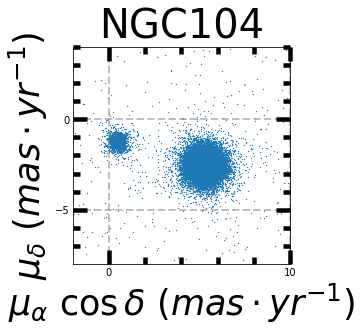

In [7]:
### Plotting time!

# P.S.: You might try to run this cell twice. Some changes in 
# Matplotlib parameters takes 2 runnings

# JSON file containing data from previous runnings
json_path_file = '../ObservedData/observed_GC_parameters.json'
usePreviousValues = True

parameters, isInJSONfile = isInJSONParametersFile(json_path_file)

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

if usePreviousValues and isInJSONfile:
    print(f'{object_name} object found in JSON file!')
    x_limit = [parameters.PM_plot_x_axis_min, parameters.PM_plot_x_axis_max]
    y_limit = [parameters.PM_plot_y_axis_min, parameters.PM_plot_y_axis_max]
    print(f'Using parameters X:{x_limit}, Y: {y_limit}')

else: # choose your custom values to plot here
    print('Using custom values for X and Y limits in plot')
    x_limit = [-2., 10.]
    y_limit = [-8, 4.]


label_fontsize = 35
ax.set_xlim(x_limit[0], x_limit[1])
ax.set_ylim(y_limit[0], y_limit[1])
plt.rcParams["figure.figsize"] = (28,21)
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
ax.scatter(filtered_r['pmra'], filtered_r['pmdec'], linewidths=0.3, s=1.)
ax.grid(color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.set(xlabel=r'$\mu_{\alpha} \ \cos \delta$ ($mas \cdot yr^{-1}$)', 
       ylabel="$\mu_{\delta}$ ($mas \cdot yr^{-1}$)")
ax.xaxis.label.set_size(label_fontsize)
ax.yaxis.label.set_size(label_fontsize)
ax.tick_params(which='both', width=4.5, top='on')
ticksize = 14
ax.tick_params(which='major',length=ticksize, direction = 'in')
ax.tick_params(which='minor',length=ticksize/2., direction = 'in')
ax.yaxis.set_ticks_position('both')
plt.minorticks_on()
plt.title(object_name.upper(), size=40)
plt.style.use('dark_background') #uncomment for dark Jupyter themes
plt.show()

## 4 -. Save the results

- Finally, if you are happy with the results, just save them. I prefer to save the data before the filtering process and after it. These objects will be saved as `1_OBJ_NAME_raw_data.dat` (data not filtered) and `1_OBJ_NAME_f_data.dat` (filtered data), where `OBJ_NAME` will be replaced with the name of your object in upper case letters, and `1` represents this data wa produced into the first step of this Notebook. Both files will be saved in a directory that will be placed in the same directory where this Notebook is with name `./Objects/OBJ_NAME`. If the directory already exists the program will not create and replace the already existing directory, it will just save the .dat files.

- For example, if we have worked with '`ngc104`' this will save files `1_NGC104_raw_data.dat` and `1_NGC104_f_data.dat` into the directory `./Objects/NGC104`. So paths to these files will be '`Objects/NGC104/1_NGC104_raw_data.dat`' and '`Objects/NGC104/1_NGC104_f_data.dat`'. 

In [8]:
# Check if 'Objects' directory -where the data is stored- exists
# If it does not exists, creates it
object_path = "../Objects"
ObjectExists, ObjectDir = os.path.exists(object_path), os.path.isdir(object_path)
if ObjectExists and ObjectDir:
    print("Object (Clusters) directory succesfully found!")
if not ObjectExists:
    print(f"Directory Object (Clusters) not found. Creating it...")
    os.makedirs(object_path)
    print(f"{object_path!r} directory succesfully created!")
    
# Directory for the object you are looking for
# E.g., if you are studying 'NGC104' object it 
# will look for "../Objects/NGC104" directory
dir_path = f"../Objects/{object_name.upper()}"

# Check whether the specified path exists or not
isExist = os.path.exists(dir_path)
isDir = os.path.isdir(dir_path)

if isExist and isDir:
    print(f"Directory for {object_name!r} already exists.")
    
if not isExist:
    print(f"Directory for {object_name!r} does not exist. Creating a new one...")
    # Create a new directory because it does not exist 
    os.makedirs(dir_path)
    print("The new directory is created!")

filename_path = f"{dir_path}/1_{object_name.upper()}"

print("\nWriting files...")
#Finally, save raw and filtered data
r.write(f"{filename_path}_raw_data.dat", format='ascii.ecsv', overwrite=True)
filtered_r.write(f"{filename_path}_f_data.dat", format='ascii.ecsv', overwrite=True)
print('Done!')

Directory Object (Clusters) not found. Creating it...
'../Objects' directory succesfully created!
Directory for 'NGC104' does not exist. Creating a new one...
The new directory is created!

Writing files...
Done!


And you are done with this step! 😉 Check the next step to continue working with data used here...